# Matrix Factorization

- Using SVD on a term-term co-occurence matrix is a simple way to create embeddings with powerfull semantic meaning

In [1]:
import pickle
import numpy as np
import pandas as pd
import nltk
import string
import sys
import matplotlib.pyplot as plt

from scipy.sparse import dok_matrix, csr_matrix, dok_array, hstack, vstack
from scipy.spatial.distance import cosine, euclidean
from scipy.sparse.linalg import svds, inv
from tqdm.notebook import tqdm

from sklearn.decomposition import TruncatedSVD, PCA

## Term-term co-occurence matrix

#### Will try to identifie words with similar meaning.
 - We will the abstracts data for this study
 
1. The data will be preprocessed
2. The Co-ocurrence matrix will be computed
3. PMI from the co-occurence matrix
4. SVD applied to the final matrix in order to create the embeddings

### Preprocessing the data
 - Removal of punctuation
 - Filtering for only alpha-numeric values
 - Conversion to lower case

In [2]:
summaries = pd.read_csv("data/arxiv_data.csv").summaries

In [3]:
summaries = summaries.apply(lambda x: x.replace("\n", " "))

In [4]:
nltk.tokenize.sent_tokenize(summaries.loc[0])

['Stereo matching is one of the widely used techniques for inferring depth from stereo images owing to its robustness and speed.',
 'It has become one of the major topics of research since it finds its applications in autonomous driving, robotic navigation, 3D reconstruction, and many other fields.',
 'Finding pixel correspondences in non-textured, occluded and reflective areas is the major challenge in stereo matching.',
 'Recent developments have shown that semantic cues from image segmentation can be used to improve the results of stereo matching.',
 'Many deep neural network architectures have been proposed to leverage the advantages of semantic segmentation in stereo matching.',
 'This paper aims to give a comparison among the state of art networks both in terms of accuracy and in terms of speed which are of higher importance in real-time applications.']

In [5]:
def get_words(document: list[str]):
    """
    Given a document, parses it's tokens, removing stopwords and punctuation;
    """
    stopwords = set(map(str.lower, nltk.corpus.stopwords.words("english")))
    punctuation = set(string.punctuation)
    for word in nltk.tokenize.word_tokenize(document):
        word = word.lower()
        if (word not in stopwords) and \
        (word not in punctuation):
            yield word

In [6]:
all_words = {}
docs = []
index = 0
for abstract in tqdm(summaries):
    for sentence in nltk.tokenize.sent_tokenize(abstract):
        current_sentence = []
        for word in get_words(sentence):
            if word not in all_words:
                all_words|= {word:index}
                index+=1
            current_sentence.append(word)
        docs.append(current_sentence)

  0%|          | 0/51774 [00:00<?, ?it/s]

In [7]:
len(all_words)

100649

In [8]:
with open("data/arxiv_abstracts_no_stopwords.pickle", "wb") as f:
    pickle.dump((all_words, docs), f)

### Computation of the co-ocurrence matrix with a sliding window of size {wsize} and application of PMI transformation.

We will assume log(0) = 0

In [9]:
all_words, docs = pickle.load(open("data/arxiv_abstracts_no_stopwords.pickle", "rb"))

In [10]:
rev_words = { item[1]:item[0] for item in all_words.items() }

In [11]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

In [12]:
M = len(all_words)
M

100649

In [13]:
wsize = 5

In [16]:
def count_word_coocurrence(docs, wsize=10):
    term_term_dict = {}
    for doc in tqdm(docs):
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                term_term_dict[ (prev_word, current_word) ] = term_term_dict.get(
                    (prev_word, current_word),
                    0
                ) + 1
                term_term_dict[ (future_word, current_word) ] = term_term_dict.get(
                    (future_word, current_word),
                    0
                ) + 1
                
    term_term_sparse = dok_matrix((M,M))
    for idx, value in term_term_dict.items():
        i, j = idx
        term_term_sparse[i, j] = value
        
    return term_term_sparse

In [17]:
word_cooc_count = count_word_coocurrence(docs, wsize=wsize)

  0%|          | 0/397123 [00:00<?, ?it/s]

In [23]:
def PMI(cooc):
    total = cooc.sum()
    probs = cooc/total
    word_probs = probs.sum(axis=0)
    
    PMI = dok_matrix(cooc.shape)
    ceil = 999999
    for i,j in tqdm(cooc.keys()):
        den = (word_probs[0,i] * word_probs[0, j])
        if den == 0:
            ratio = ceil
        else:
            ratio = probs[i,j] / den
            
        if ratio > 0:
            PMI[i,j] = np.log(ratio)
            
    return PMI
            

In [24]:
pmi = PMI(word_cooc_count)

  0%|          | 0/6134986 [00:00<?, ?it/s]

### Transforming the Sparse Co-occurence matrix into a N-Dim dense matrix using SVD

In [25]:
pmi

<100649x100649 sparse matrix of type '<class 'numpy.float64'>'
	with 6134986 stored elements in Dictionary Of Keys format>

In [26]:
u = TruncatedSVD(n_components=100).fit_transform(pmi)

In [27]:
[int2word(i) for i in range(1000,1005)]

['adaptive', 'implemented', 'retain', 'access', 'receptive']

In [28]:
np.argsort([ 
    euclidean(
        u[word2int("programming")], 
        u[i]
    ) for i in range(len(u))
])[:15]

array([1925, 3529, 7526, 5156, 4206, 9231,  700, 7420,  600, 3542, 8176,
        611, 4151, 1941, 1215], dtype=int64)

In [40]:
tempw = int2word(7526)
tempw 

'program'

In [36]:
temp = word2int("cnn")
temp

992

In [37]:
cnn_near = np.argsort([ 
    euclidean(
        u[word2int("cnn")], 
        u[i]
    ) for i in range(len(u))
])[:15]

In [38]:
cnn_near

array([ 992,  450,  489,   47,  961,  907, 1292, 1140, 2396, 2057, 5073,
        377,  138,  945,  497], dtype=int64)

In [41]:
random = np.random.choice(list(range(len(u))), size=15, replace=False)

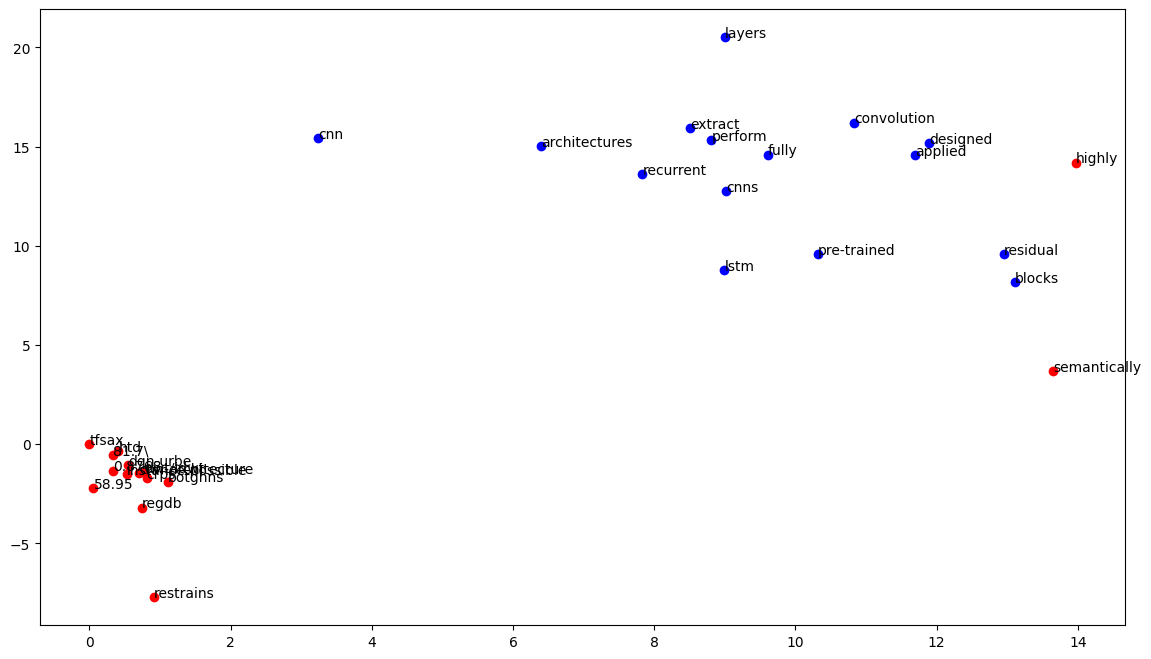

In [42]:

plt.figure(figsize=(14,8))
for i in cnn_near:
    plt.scatter(u[i,0], u[i,1], c="b") #int2word(i))
    plt.text(u[i,0], u[i,1],int2word(i))
    
for i in random:
    plt.scatter(u[i,0], u[i,1], c="r") 
    plt.text(u[i,0], u[i,1],int2word(i))

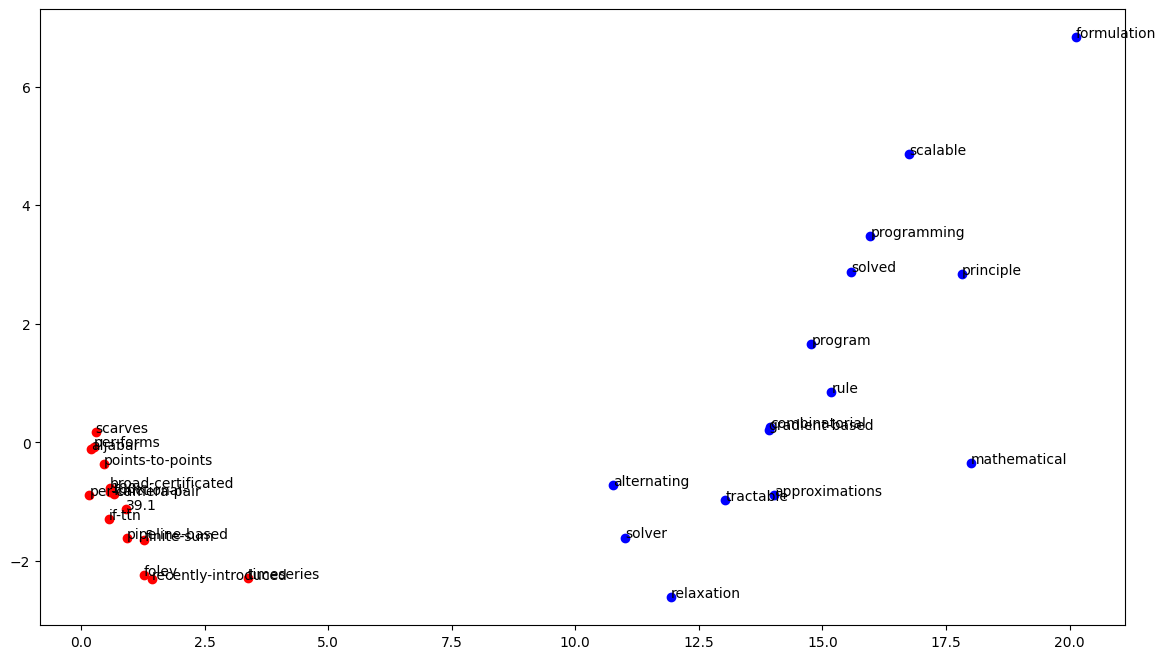

In [43]:
prog_near = np.argsort([ 
    euclidean(
        u[word2int("programming")], 
        u[i]
    ) for i in range(len(u))
])[:15]

random = np.random.choice(list(range(len(u))), size=15, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(u[i,0], u[i,1], c="b") #int2word(i))
    plt.text(u[i,0], u[i,1],int2word(i))
    
for i in random:
    plt.scatter(u[i,0], u[i,1], c="r") 
    plt.text(u[i,0], u[i,1],int2word(i))

We can see that the words are close to words that have similar meanings, for example the 'cnn' is around words related to neural networks. Words close to programming are overal related with the word topic too.